##인공지능개론 Project Model 1 : EMNIST Digit/Letter Classification

In [358]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from ProjectUtils import *
import matplotlib.pyplot as plt
import random

In [359]:
SEED = 8339
random.seed(SEED) # python
torch.manual_seed(SEED) # torch
torch.cuda.manual_seed(SEED) # cuda

> Define Hyper Parameters

In [360]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# hyper parameters
num_classes = 2 # 고정값 (digit = 0, letter = 1)
input_size = 28 # 고정값
sequence_length = 28 # 고정값
num_epochs = 8
learning_rate = 0.001 
batch_size = 256 
hidden_dim = 128 
num_layers = 3 
drop_percent = 0.2 

>  Load Data and Define Data Loader : EMNIST _ Digit and Letter

In [361]:
train_data = TypeData(train=True)
test_data = TypeData(train=False)

In [362]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

>  Build Model for EMNIST Digit/Letter Classification

In [363]:
class Model1(nn.Module):
  def __init__(self, input_size, hidden_dim, num_layers, num_classes, drop_percent):
    super(Model1, self).__init__()
    self.hidden_size = hidden_dim
    self.num_layers = num_layers

    self.drop_percent = drop_percent
    self.dropout = nn.Dropout(drop_percent)

    self.fc = nn.Linear(hidden_dim, num_classes)
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.dropout(out)
    out = self.fc(out[:,-1,:])

    return out

In [364]:
model = Model1(input_size, hidden_dim, num_layers, num_classes, drop_percent).to(device)

>Define Loss Function and Optimizer

In [365]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

> Begin Training Model1

In [366]:
best_epoch = 0
best_loss = float('inf')
total_step = len(train_loader)
loss_list = []

In [367]:
start = time.time()
for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image = image.reshape(-1, sequence_length, input_size).to(device)
    label = label.to(device).long()

    # Forward
    output = model(image)
    loss = criterion(output, label)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    if loss.item() < best_loss:
      best_loss = loss.item()
      torch.save(model.state_dict(), "20181202_model1.pth")

    if (i+1) % 1000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print("\n>> Train takes {:.2f}minutes".format((end-start)/60))

Epoch [1/8], Step[1000/2727], Loss:0.2947
Epoch [1/8], Step[2000/2727], Loss:0.1744
Epoch [2/8], Step[1000/2727], Loss:0.1760
Epoch [2/8], Step[2000/2727], Loss:0.1462
Epoch [3/8], Step[1000/2727], Loss:0.1720
Epoch [3/8], Step[2000/2727], Loss:0.1536
Epoch [4/8], Step[1000/2727], Loss:0.1647
Epoch [4/8], Step[2000/2727], Loss:0.1666
Epoch [5/8], Step[1000/2727], Loss:0.1791
Epoch [5/8], Step[2000/2727], Loss:0.1849
Epoch [6/8], Step[1000/2727], Loss:0.1656
Epoch [6/8], Step[2000/2727], Loss:0.1685
Epoch [7/8], Step[1000/2727], Loss:0.1141
Epoch [7/8], Step[2000/2727], Loss:0.1695
Epoch [8/8], Step[1000/2727], Loss:0.1342
Epoch [8/8], Step[2000/2727], Loss:0.1519

>> Train takes 14.07minutes


> Show the Loss Graph of Training

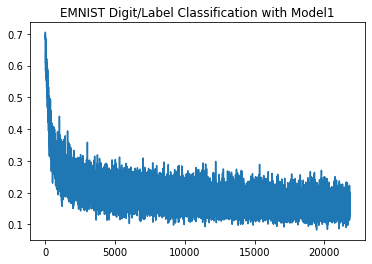

In [370]:
plt.plot(loss_list)
plt.title("EMNIST Digit/Label Classification with Model1")
plt.show()

> Test Model1 and Show Accuracy

In [371]:
model.load_state_dict(torch.load('./20181202_model1.pth'))

with torch.no_grad():
  correct = 0
  
  for image, label in test_loader:
    image = image.reshape(-1, sequence_length, input_size).to(device)
    label = label.to(device)
    output = model(image)
    _ , pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

  print("Accuracy of Model1 on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

Accuracy of Model1 on the 116480 test images: 92.05528846153847%
